# Reading and plotting graph-percolation data

In [7]:
import os
#%cd "C:/Users/fandreoli/Github Repos/random_graph_percolation"
print("The working directory is: ", str(os.getcwd()))
data_dir = "Data\\"

The working directory is:  c:\Users\fandreoli\Github Repos\random_graph_percolation


## Computing the data

### Graph size choice

In [29]:
N_nodes = (10**2)
override_data = [True, False][0]

In [30]:
def time_display(time_sec):
    return time.strftime("%H:%M:%S", time.gmtime(time_sec ))

def dir_create(dir_path):
    try:
        os.mkdir(dir_path)
        print(f"Created directory '{dir_path}'.")
    except FileExistsError:
        pass
    except PermissionError:
        print(f"Permission denied: Unable to create '{dir_path}'.")
    except Exception as e:
        raise(f"When creating {dir_path}, the following error occurred: {e}")

if "g_mean_"+str(N_nodes)+".dat" in set(os.listdir(data_dir)) and not override_data:
    print("The data have already been computed.")
else:
    import time
    print("Executing the C script to compute the data.")
    dir_create(data_dir)
    dir_create(data_dir+"\\Temp")
    time_start = time.time()
    os.system('gcc random_graph.c -o random_graph.exe')
    time_compile = time.time()
    os.system('random_graph.exe '+str(N_nodes)+' '+data_dir)
    time_end = time.time()
    print("Script completed in ",time_display(time_end-time_start))
    print("Compilation time: ",time_display(time_compile-time_start))
    print("Execution time: ",time_display(time_end-time_compile))

Executing the C script to compute the data.
Script completed in  00:00:02
Compilation time:  00:00:00
Execution time:  00:00:02


## Importing the data

### Defining the data to import

In [31]:
graph_sizes = [int(10**pow) for pow in range(2,8)]

### Importing

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def size_file_extract(current_file):
    return int(current_file.replace("g_mean_","").replace(".dat",""))
    
file_names = ["g_mean_"+str(sizes)+".dat" for sizes in graph_sizes]
file_names = set(file_names) & set(os.listdir(data_dir))
file_names = list(file_names)
file_names.sort()
graph_sizes = [size_file_extract(current_file) for current_file in file_names]
print("Sizes to analyze: ", graph_sizes)

sol_dict=dict({})
for i,current_file in enumerate(file_names):
    size = graph_sizes[i]
    current_file = data_dir+current_file
    try:
        sol_dict[size] = pd.read_csv(current_file, delimiter=",")
    except Exception as error_here:
        print("You got an error when either parsing the data file:", current_file)
        raise(error_here)
    sol_dict[size].columns = [col.replace(" ", "") for col in sol_dict[size].columns]
 

Sizes to analyze:  [100, 1000, 10000, 100000, 1000000, 10000000]


## Plotting the data

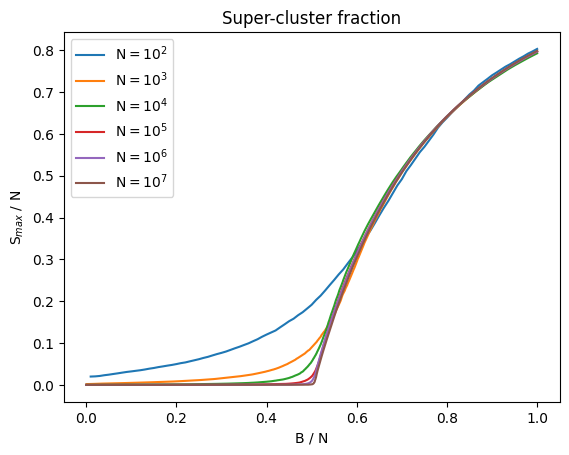

In [33]:
import numpy as np
for size in graph_sizes:
    plt.plot(sol_dict[size]['c'], sol_dict[size]['Smax_mean'],label="N$ = 10^{{{}}}$".format(round(np.log10(size))))
    
plt.legend()
plt.xlabel("B / N")
plt.ylabel("S$_{max}$ / N")
plt.title("Super-cluster fraction")

plt.show()

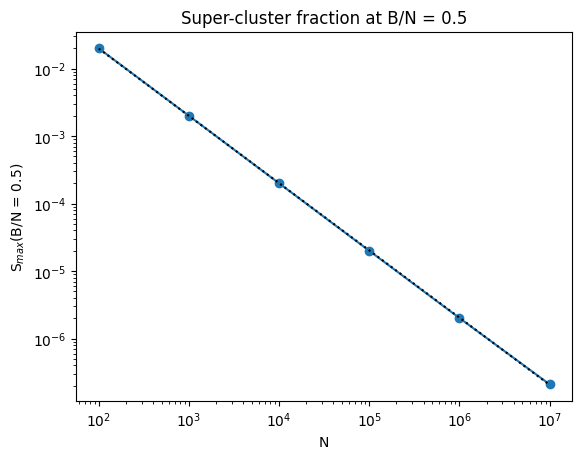

The scaling is 2.0*N^(-1.0)


In [40]:
phase_transition_list = pd.DataFrame({"N":graph_sizes,"S*_max":[0.0 for _ in range(0,len(graph_sizes))]})
for i,size in enumerate(graph_sizes):
    val = sol_dict[size].sort_values(by='c', key=lambda val: abs(val-0.5))['Smax_mean'][0]
    phase_transition_list.loc[i, "S_max"] = val
    
plt.loglog(phase_transition_list['N'],phase_transition_list['S_max'])

import numpy as np
fit_array = np.polyfit(np.log10(phase_transition_list['N']),np.log10(phase_transition_list['S_max']),1)
x_fit_range = np.arange(min(np.log10(graph_sizes)),max(np.log10(graph_sizes)),0.01)
y_fit_range = np.array([(lambda y :fit_array[1]+y*fit_array[0] )(x) for x in x_fit_range])
plt.loglog(10**x_fit_range,10**y_fit_range, linestyle=':', color='black')

plt.scatter(phase_transition_list['N'],phase_transition_list['S_max'])

plt.xlabel("N")
plt.ylabel("S$_{max}$(B/N = 0.5)")
plt.title("Super-cluster fraction at B/N = 0.5")


plt.show()

def decimal_round(num,digits=1):
    return round(num*10**digits)/10**digits
print("The scaling is "+str(decimal_round(10**fit_array[1]))+"*N^("+str(decimal_round(fit_array[0]))+")")
